In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from PIL import Image

import os
import pandas as pd
import skimage.io
from skimage.transform import resize


%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
RESCALE_SIZE = 100 #100 #160 #224

# dataset
данные лиц 500 людей CelebA-500. Они уже выровнены. Скачать можно тут: https://disk.yandex.ru/d/S8f03spLIA1wrw  
    Внутри:  
        - celebA_imgs — папка с выровненными картинками;  
        - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;  
        - celebA_train_split.txt — файл со сплитом на train/val/test.  
    Эти данные — часть открытого датасета [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html), который один из стандартных для обучения моделей, связанных с лицами.  

In [3]:
#read attrs
df_attrs = pd.read_csv("/kaggle/input/celeba/data/celebA_train_500/celebA_anno.txt", header=None, sep=' ')
df_attrs.columns = ['name_img', 'id']
df_attrs.head()

,name_img,id
0,000001.jpg,0
1,000404.jpg,0
2,003415.jpg,0
3,004390.jpg,0
4,018062.jpg,0


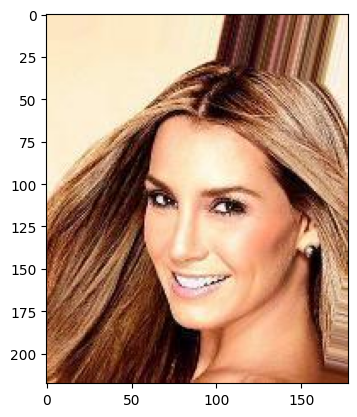

In [4]:
img = skimage.io.imread("/kaggle/input/celeba/data/celebA_train_500/celebA_imgs/000001.jpg")
plt.imshow(img);

In [5]:
#train val test split
split = pd.read_csv("/kaggle/input/celeba/data/celebA_train_500/celebA_train_split.txt", header=None, sep=' ')
split.columns = ['name_img', 'class']
split.head()

,name_img,class
0,000001.jpg,0
1,000404.jpg,0
2,003415.jpg,0
3,004390.jpg,0
4,018062.jpg,0


In [6]:
class CustomDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, path, files, labels, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = files
        self.labels = labels
        # режим работы
        self.mode = mode
        self.path = path

        self.len_ = len(self.files)


    def __len__(self):
        return self.len_

    def load_sample(self, file):
        if self.mode != 'metric':
            image = np.array(Image.open(f'{self.path}/{file}'))
            image = Image.fromarray(image[77:-41,45:-50])
        else:
            image = Image.open(f'{self.path}/{file}')
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.RandomRotation(degrees=30),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        aug = transforms.Compose([
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip()
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)       
        #x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'train':
            x = aug(x)

        if self.labels: 
            label = self.labels[self.files[index]]
        else:
            label = 0
        return x, label

    def _prepare_sample(self, image):
#         padding = transforms.Pad(padding=((RESCALE_SIZE - image.size[1]) // 2, (RESCALE_SIZE - image.size[0]) // 2))
#         image = padding(image)
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
train_files = list(split[split['class'] == 0]['name_img'])
val_files = list(split[split['class'] == 1]['name_img'])
test_files = list(split[split['class'] == 2]['name_img'])

In [8]:
labels = dict(zip(df_attrs['name_img'], df_attrs['id']))

In [9]:
# read images
img_path = '/kaggle/input/celeba/data/celebA_train_500/celebA_imgs'
train_dataset = CustomDataset(img_path,train_files, labels, mode='train')
val_dataset = CustomDataset(img_path,val_files, labels, mode='val')
test_dataset = CustomDataset(img_path,test_files, labels, mode='test')

In [10]:
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# model

In [11]:
# Set the seed for PyTorch
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#### ArcFace Loss (Additive Angular Margin Loss)

В случае с обучением на задачу классификации лосс-функция, которая нам приходит в голову — Cross-Entropy. И на нее действительно можно обучать сеть для распознавания лиц. Но за много лет люди придумали более хитрые лосс-функции, которые делают обучение сети для распознавания лиц более эффективным. Одним из лучших считается ArcFace Loss (Additive Angular Margin Loss).

Этот лосс — чуть измененная кросс-энтропия. Он позволяет достичь лучшего распределения векторов лиц на сфере. В нем добавлены некоторые дополнительные ограничения и гиперпараметры, для того чтобы эмбеддинги лиц одного класса были более близки между собой, а эмбеддинги лиц разных людей оставались далеки. То есть, этот лосс позволяет лучше кластеризовать лица на сфере единичного радиуса.


**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными допатрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация эмбеддингов приводит к тому, что эмбеддинги начинают быть распределены по сфере единичного радиуса (и сфере радиуса s после умножения на ниперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угод между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss завтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.



**Доплитература по ArcFace Loss:**

Оригинальная статья: https://arxiv.org/pdf/1801.07698.pdf

Репозиторий с кодом: https://github.com/deepinsight/insightface

In [51]:
class ArcFaceLoss(nn.Module):
    def __init__(self, s=30.0, m=0.5):
        super(ArcFaceLoss, self).__init__()
        self.s = s
        self.m = m

    def forward(self, emb, labels, model):
        state_dict = model.state_dict()
        keys = list(state_dict.keys())
        last_layer_key = keys[-2]
        last_layer_weights = state_dict[last_layer_key]
        last_layer_weights = last_layer_weights.T
        last_layer_weights_norm = F.normalize(last_layer_weights, dim=1)
        emb_norm = F.normalize(emb, dim=0)

        weights_y = last_layer_weights_norm[:, labels]
        # cos(a+b)=cosa⋅cosb−sina⋅sinb
        cos_teta_y = F.cosine_similarity(weights_y.T, emb_norm)
        sin_teta_y = torch.sqrt(1 - cos_teta_y**2)
        sin_m = torch.sin(torch.tensor(self.m))
        cos_m = torch.cos(torch.tensor(self.m))
        cos_teta_y_plus_m = cos_teta_y * cos_m - sin_teta_y * sin_m
        up = torch.exp(self.s * cos_teta_y_plus_m)

        not_y_labels = torch.tensor([value for value in range(500) if value not in labels])       
        other_weights = last_layer_weights_norm[:, not_y_labels]
        # angle between wj and x
        dot_product = emb_norm @ other_weights
        magnitude_A = torch.norm(other_weights.T)
        magnitude_B = torch.norm(emb_norm)
        cos_teta_j = dot_product / magnitude_A * magnitude_B
        
        exp_j = torch.exp(self.s * cos_teta_j)
        down = up + (exp_j).sum(dim=1)
        
        # from cross entropy function after softmax
        batch_size = len(labels)
        probs = up / down
        log_probs = torch.log(probs + 1e-10)
        loss = -log_probs.mean()    

        return loss

In [52]:
# af_loss = ArcFaceLoss(5, 0.2)
# af_loss(emb, labels, model)

In [53]:
df_attrs['id'].nunique()

500

In [54]:
n_classes = 500

In [55]:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [149]:
model = models.resnet18(weights='IMAGENET1K_V1')

In [150]:
# model

In [151]:
# Freeze all layers except the last two residual blocks and the fully connected layer
for param in model.parameters():
    param.requires_grad = True
    
# for param in model.layer1.parameters():
#     param.requires_grad = True
    
# for param in model.layer2.parameters():
#     param.requires_grad = True

# for param in model.layer3.parameters():
#     param.requires_grad = True

# for param in model.layer4.parameters():
#     param.requires_grad = True


model.fc = nn.Linear(model.fc.in_features, n_classes)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-8, betas=(0.95, 0.999))

In [152]:
# add to get embeddings x from last layer before muliplying to weights (for arc face loss)
class CustomResNet(nn.Module):
    def __init__(self, model, n_classes):
        super(CustomResNet, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-2])
        
        # Define the new fully connected layers
        self.fc = nn.Sequential(
                    nn.Linear(model.fc.in_features, n_classes),
        )


    def forward(self, x):
        features_before_fc = self.features(x)
        features_before_fc = torch.mean(features_before_fc, dim=[2, 3])
        features_before_fc = features_before_fc.view(features_before_fc.size(0), -1)

        final_output = self.fc(features_before_fc)

        # embeddings before last layer and final output logits
        return features_before_fc, final_output

In [153]:
model = CustomResNet(model, n_classes)

In [154]:
n_epochs = 25
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
# with big s cannot count exp properly (goes to nan values)
criterion = ArcFaceLoss(3, 0.5)

train_losses = []
val_losses = []
train_acc = []
val_acc = []

torch.autograd.set_detect_anomaly(True)
for epoch in tqdm_notebook(range(n_epochs)):
    # Training phase
    model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        emb, outputs = model(inputs)
        # print(emb.shape, outputs.shape)
        loss = criterion(emb, labels, model)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    average_loss = total_loss / len(train_loader)
    accuracy = correct / total_samples
    
    train_losses.append(average_loss)
    train_acc.append(accuracy)

    print(f"Epoch [{epoch + 1}/{n_epochs}], Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy:.4f}")
    
    # Validation phase
    model.eval()
    validation_loss = 0.0
    val_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_emb, val_outputs = model(val_inputs)
            val_loss = criterion(val_emb, val_labels, model)
            
            validation_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total_samples += val_labels.size(0)

    avg_val_loss = validation_loss / len(val_loader)
    val_accuracy = val_correct / val_total_samples
    
    val_losses.append(avg_val_loss)
    val_acc.append(val_accuracy)
    print(f"Epoch [{epoch + 1}/{n_epochs}], Val Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

/tmp/ipykernel_26/2874652621.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/25], Train Loss: 7.6381, Train Accuracy: 0.0179
Epoch [1/25], Val Loss: 7.6091, Validation Accuracy: 0.0522
Epoch [2/25], Train Loss: 7.4799, Train Accuracy: 0.1320
Epoch [2/25], Val Loss: 7.5318, Validation Accuracy: 0.1613
Epoch [3/25], Train Loss: 7.3619, Train Accuracy: 0.3091
Epoch [3/25], Val Loss: 7.4545, Validation Accuracy: 0.2721
Epoch [4/25], Train Loss: 7.2391, Train Accuracy: 0.4671
Epoch [4/25], Val Loss: 7.3891, Validation Accuracy: 0.3557
Epoch [5/25], Train Loss: 7.1100, Train Accuracy: 0.5959
Epoch [5/25], Val Loss: 7.3129, Validation Accuracy: 0.4308
Epoch [6/25], Train Loss: 6.9840, Train Accuracy: 0.6886
Epoch [6/25], Val Loss: 7.2429, Validation Accuracy: 0.4963
Epoch [7/25], Train Loss: 6.8628, Train Accuracy: 0.7588
Epoch [7/25], Val Loss: 7.1597, Validation Accuracy: 0.5378
Epoch [8/25], Train Loss: 6.7421, Train Accuracy: 0.8106
Epoch [8/25], Val Loss: 7.1067, Validation Accuracy: 0.5639
Epoch [9/25], Train Loss: 6.6332, Train Accuracy: 0.8441
Epoch [

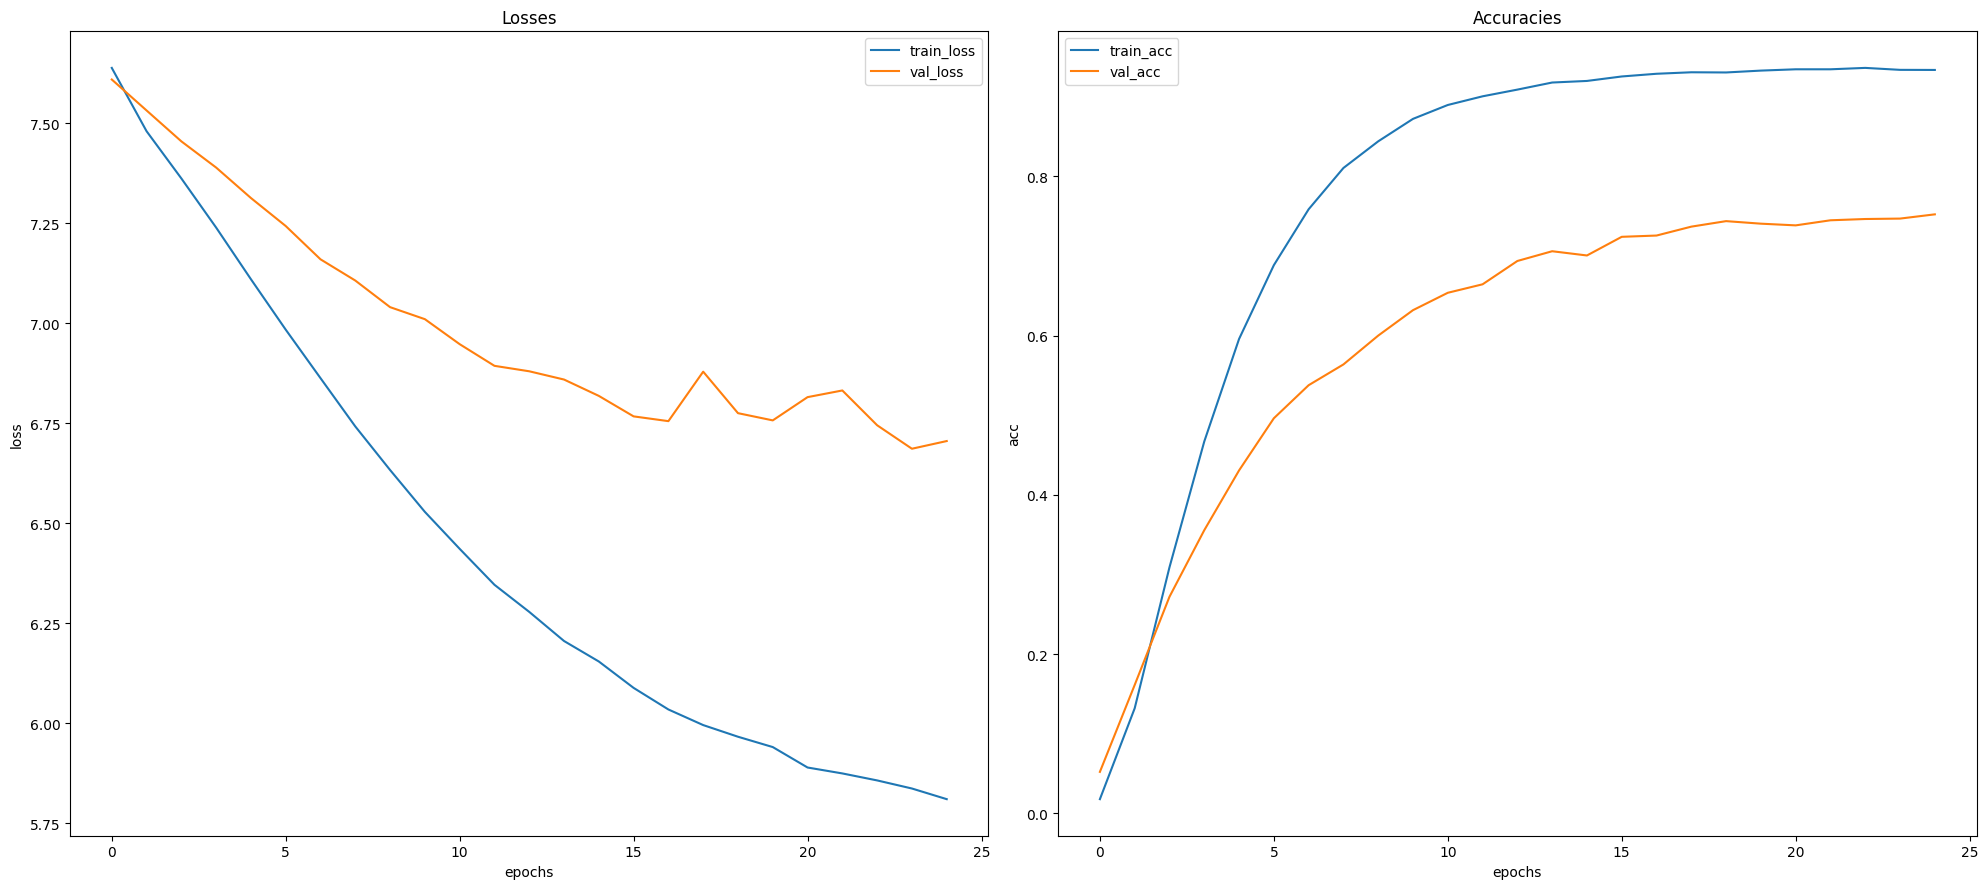

In [155]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 9))

axes[0].plot(train_losses, label="train_loss")
axes[0].plot(val_losses, label="val_loss")
axes[0].legend(loc='best')
axes[0].set_xlabel("epochs")
axes[0].set_ylabel("loss")
axes[0].set_title("Losses")

axes[1].plot(train_acc, label="train_acc")
axes[1].plot(val_acc, label="val_acc")
axes[1].legend(loc='best')
axes[1].set_xlabel("epochs")
axes[1].set_ylabel("acc")
axes[1].set_title("Accuracies")

plt.tight_layout()
plt.show()

In [156]:
torch.save(model, './model_af.bin')
torch.save(model.state_dict(), './model_weights_af.bin')

In [157]:
model.eval()
test_correct = 0
test_total_samples = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        emb, test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs, 1)
        test_correct += (test_predicted == test_labels).sum().item()
        test_total_samples += test_labels.size(0)

test_accuracy = test_correct / test_total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7319


Получаем качество классификации 0.73 на тестовой выборке с обучением на arc face loss в качестве лосс функции  
Достичь достаточного качества классификации (0.7 accuracy) получилось на модели resnet18 за 14+ эпох